In [ ]:
IMAGE_PATH = "../dataset/images/train/fff76754c1ede9b0.jpg"
DATASET_PATH = "../dataset/images/train"
MODEL_PATH = "../models/yolo11n_640_hface_quantized.onnx"
CONF_THRESHOLD = 0.8

In [35]:
import cv2
import numpy as np
import onnxruntime as ort
import matplotlib.pyplot as plt
import os

def process_output(
    output, conf_threshold=0.5, input_shape=(640, 640), original_shape=None
):
    predictions = output[0]
    predictions = np.transpose(predictions, (2, 1, 0)).squeeze()

    scale_x = original_shape[1] / input_shape[1]
    scale_y = original_shape[0] / input_shape[0]

    boxes = []
    for prediction in predictions:
        confidence = prediction[4]
        if confidence >= conf_threshold:
            x = prediction[0]
            y = prediction[1]
            w = prediction[2]
            h = prediction[3]

            x1 = int((x - w / 2) * scale_x)
            y1 = int((y - h / 2) * scale_y)
            x2 = int((x + w / 2) * scale_x)
            y2 = int((y + h / 2) * scale_y)

            boxes.append([x1, y1, x2, y2])

    return np.array(boxes) if boxes else np.array([])

def draw_boxes(image, boxes):
    if len(boxes) == 0:
        return image

    image_copy = image.copy()
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1 = max(0, x1), max(0, y1)
        x2, y2 = min(image.shape[1], x2), min(image.shape[0], y2)
        cv2.rectangle(image_copy, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return image_copy

In [36]:
def process_image(image_path, session):
    # Load and preprocess image
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_shape = image.shape
    original_image = image.copy()

    # Resize for model input
    image = cv2.resize(image, (640, 640))

    # Prepare input
    image_input = image.astype(np.float32)
    image_input /= 255.0
    image_input = np.transpose(image_input, (2, 0, 1))
    image_input = np.expand_dims(image_input, axis=0)

    # Run inference
    input_name = session.get_inputs()[0].name
    output_name = session.get_outputs()[0].name
    output = session.run([output_name], {input_name: image_input})

    # Process predictions
    boxes = process_output(output, CONF_THRESHOLD, (640, 640), original_shape)

    # Draw boxes
    image_with_boxes = draw_boxes(original_image, boxes)

    return image_with_boxes


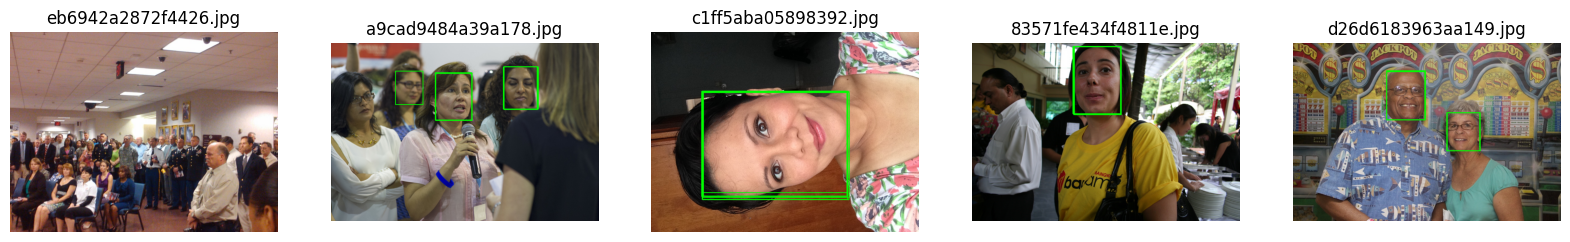

In [37]:
session = ort.InferenceSession(MODEL_PATH)
image_files = [
    f for f in os.listdir(DATASET_PATH) if f.endswith((".jpg", ".jpeg", ".png"))
]

num_samples = 5

random_files = np.random.choice(image_files, num_samples, replace=False)

fig, axs = plt.subplots(1, num_samples, figsize=(20, 5))
for i, image_file in enumerate(random_files):
    image_path = os.path.join(DATASET_PATH, image_file)
    image_with_boxes = process_image(image_path, session)
    axs[i].imshow(image_with_boxes)
    axs[i].axis("off")
    axs[i].set_title(image_file)

plt.show()